<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Flask_Yolo_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 23 08:46:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Tạo môi trường để sử dung Yolo
!pip install opencv-python==4.4.0.46 -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 49.5MB 61kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [3]:
#Thư viện web trên colab
!pip install flask-ngrok

In [4]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [6]:
#608X608
# load in our YOLOv4 architecture network
from darknet import *
from Function import *
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

In [7]:
#Hàm detection people
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [8]:
#Hiện thị ảnh Detection.(DÙNG ĐỂ TEST)
def Detection(detections,image):
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  return image

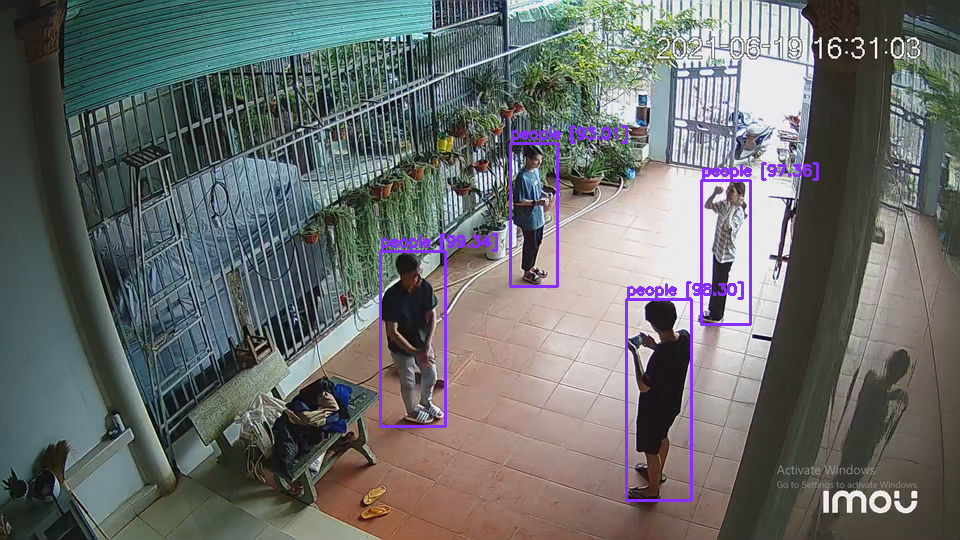

In [10]:
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/Image_Home.png")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
boxes = [bbox for _,_,bbox in detections]
img_tesst=Detection(detections,image)
cv2_imshow(img_tesst)

In [ ]:
# Tính khoảng cách theo pixel trước khi Perspective Transform
p1, p2 = (1066 ,429), (1450,503)
cv2.circle(image,p1, 10, (0,0,255), -1)
cv2.circle(image,p2, 10, (0,0,255), -1)
cv2.line(image,p1,p2,(255,128,0),4)
dst = int(np.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
text_pt_x = int((p1[0]+p2[0]) / 2)
text_pt_y = int((p1[1]+p2[1]) / 2)
cv2.putText(image, str(dst), (text_pt_x,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,128,0), 5, cv2.LINE_AA)
#Tính khoảng cách theo pixel trước khi Perspective Transform
p1, p2 = (1317,800), (825 ,678)
cv2.circle(image,p1, 10, (0,0,255), -1)
cv2.circle(image,p2, 10, (0,0,255), -1)
cv2.line(image,p1,p2,(255,128,0),4)
dst = int(np.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
text_pt_x = int((p1[0]+p2[0]) / 2)
text_pt_y = int((p1[1]+p2[1]) / 2)
cv2.putText(image, str(dst), (text_pt_x,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,128,0), 5, cv2.LINE_AA)

In [11]:
original_image_BGR = cv2.imread('/content/Image_Home.png')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


In [12]:
src = np.float32([[571.,151.],
                           [786., 185.],
                           [690., 521.],
                           [ 283., 400.]])
widthA=np.sqrt((src[0][0]-src[1][0])**2+(src[0][1]-src[1][1])**2)
widthB=np.sqrt((src[2][0]-src[3][0])**2+(src[2][1]-src[3][1])**2)
widthA=int(widthA)
widthB=int(widthB)
maxWidth=max(widthA,widthB)
heightA=int(np.sqrt((src[0][0]-src[3][0])**2+(src[0][1]-src[3][1])**2))
heightB=int(np.sqrt((src[1][0]-src[2][0])**2+(src[1][1]-src[2][1])**2))
maxHeight=max(heightA,heightB)

In [13]:
dst=np.float32([(0,0), (maxWidth-1, 0), (maxWidth-1,maxHeight-1), (0,maxHeight-1)])
#dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])
dst_size=(maxWidth,maxHeight)
def H_matrix(src,dst):
   H_matrix = cv2.getPerspectiveTransform(src, dst)
   return H_matrix
H_matrix=H_matrix(src,dst)
print(H_matrix)



[[ 3.36182143e+00  3.88837177e+00 -2.50674417e+03]
 [-7.41876309e-01  4.69127666e+00 -2.84771403e+02]
 [-3.09033126e-04  6.83333925e-03  1.00000000e+00]]


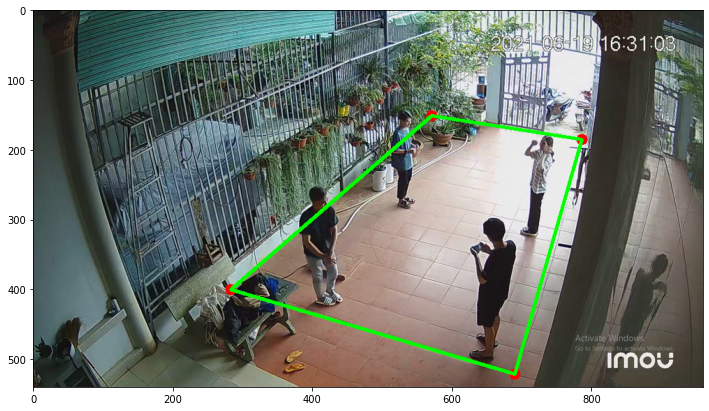

In [14]:
from Function import *
Draw_Point4(original_image_RGB_copy,src)

In [15]:
#3 Point để tính distance pixel image so với thực tế
pts= np.float32([[[445., 410.],
                  [662., 474.],
                  [535., 304.]]])
distance_w,distance_h=distance_pixel(pts,H_matrix)
print(distance_w,distance_h)

227.8971549786236 101.51690791171853


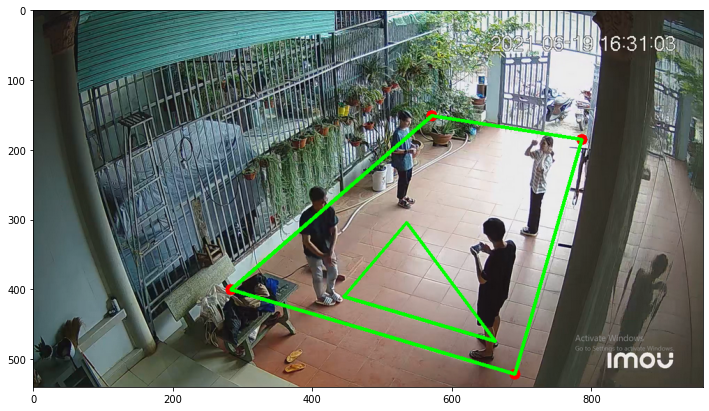

In [16]:
#Visualize
Draw_Point3(original_image_RGB_copy,pts)

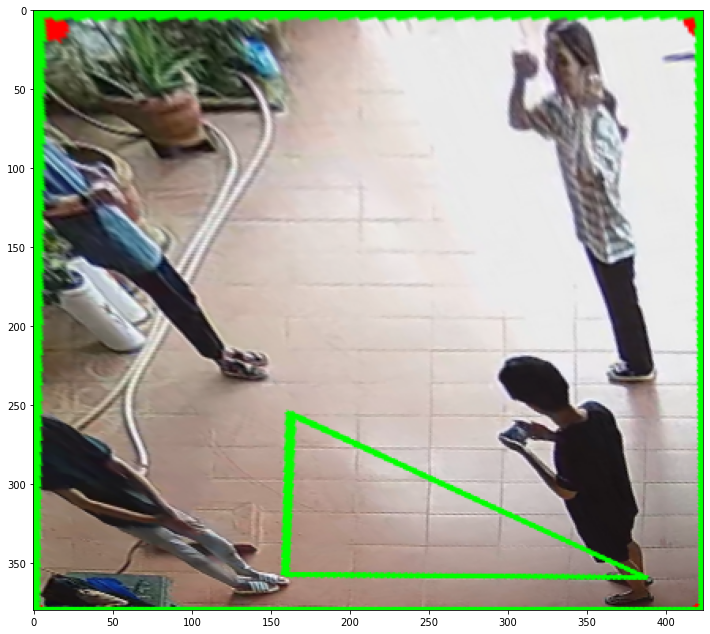

In [17]:
#Chuyển đổi matrix camera
Perspective(original_image_RGB_copy,H_matrix,dst_size)

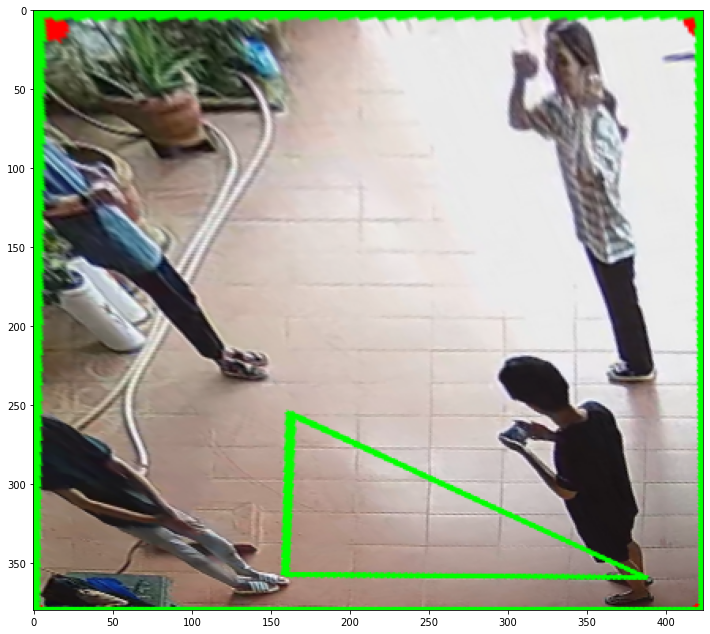

In [18]:
  warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)
  plt.figure(figsize=(12, 12))
  plt.imshow(warped)
  plt.show()

In [ ]:
def eucledian_distance_1(point1, point2,distance_w, distance_h):
    x1,y1 = point1
    x2,y2 = point2
    h=abs(y2-y1)
    w=abs(x2-x1)
    dis_w = float((w/distance_w)*200)
    dis_h = float((h/distance_h)*200)
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

In [ ]:
# Example 1
p1, p2 = (142 ,237), (398,233)
cv2.circle(warped,p1, 10, (0,0,255), -1)
cv2.circle(warped,p2, 10, (0,0,255), -1)
cv2.line(warped,p1,p2,(255,128,0),4)
dst = eucledian_distance_1(p1,p2,distance_w,distance_h)
text_pt_x = int((p1[0]+p2[0]) / 2)
text_pt_y = int((p1[1]+p2[1]) / 2)
cv2.putText(warped, str(dst), (text_pt_x-40,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,128,0), 4, cv2.LINE_AA)
# Example 2
p1, p2 = (392 ,373), (142,372)
cv2.circle(warped,p1, 10, (0,0,255), -1)
cv2.circle(warped,p2, 10, (0,0,255), -1)
cv2.line(warped,p1,p2,(255,128,0),4)
dst = eucledian_distance_1(p1,p2,distance_w,distance_h)
text_pt_x = int((p1[0]+p2[0]) / 2)
text_pt_y = int((p1[1]+p2[1]) / 2)
cv2.putText(warped, str(dst), (text_pt_x-40,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,128,0), 4, cv2.LINE_AA)


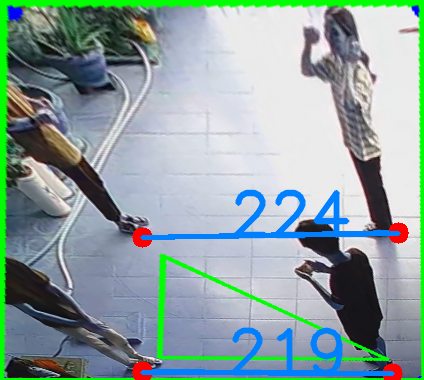

In [ ]:
cv2_imshow(warped)

In [20]:
def Point_transform_2(H_matrix,boxes):
      list_downoids = [[bbox[0]*width_ratio,bbox[1]*height_ratio+height_ratio*bbox[3]//2] for bbox in boxes]
      list_points_to_detect=np.float32(list_downoids).reshape(-1,1,2)
      transformed_point=cv2.perspectiveTransform(list_points_to_detect,H_matrix)
      transformed_point_list= list()
      for i in range (0,transformed_point.shape[0]):
        transformed_point_list.append([transformed_point[i][0][0],transformed_point[i][0][1]])
      return np.array(transformed_point_list).astype('int')

In [21]:
#Tính Position People sau khi chuyển đổi qua bird-eye 
birds_eye_points=Point_transform_2(H_matrix,boxes)

In [22]:
min_distance = 200
green_box,red_box=get_red_green_boxes_1(min_distance,birds_eye_points,boxes,distance_w,distance_h)

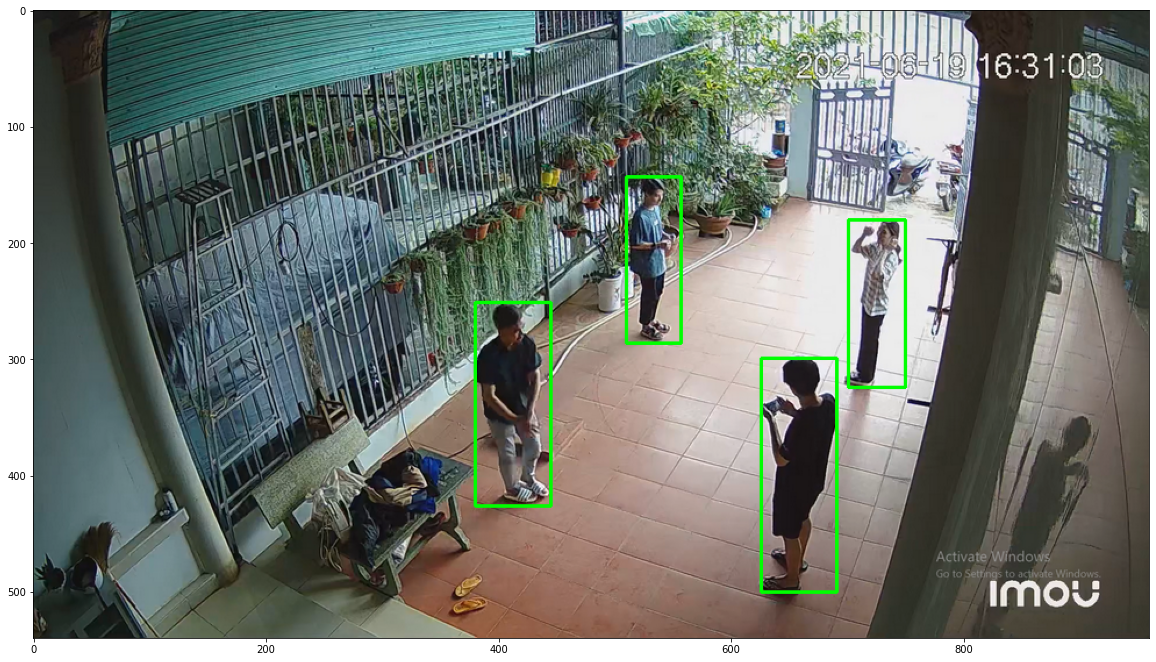

In [23]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box,width_ratio,height_ratio)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

In [24]:
def get_birds_eye_view_image(green_box, red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/black_background.png')
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    cv2.putText(blank_image, str(len(red_box)), (80,60), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (300,60), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    
    for point in green_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    return blank_image

In [25]:
#Chuyển đổi lên map bird-eye-view
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)

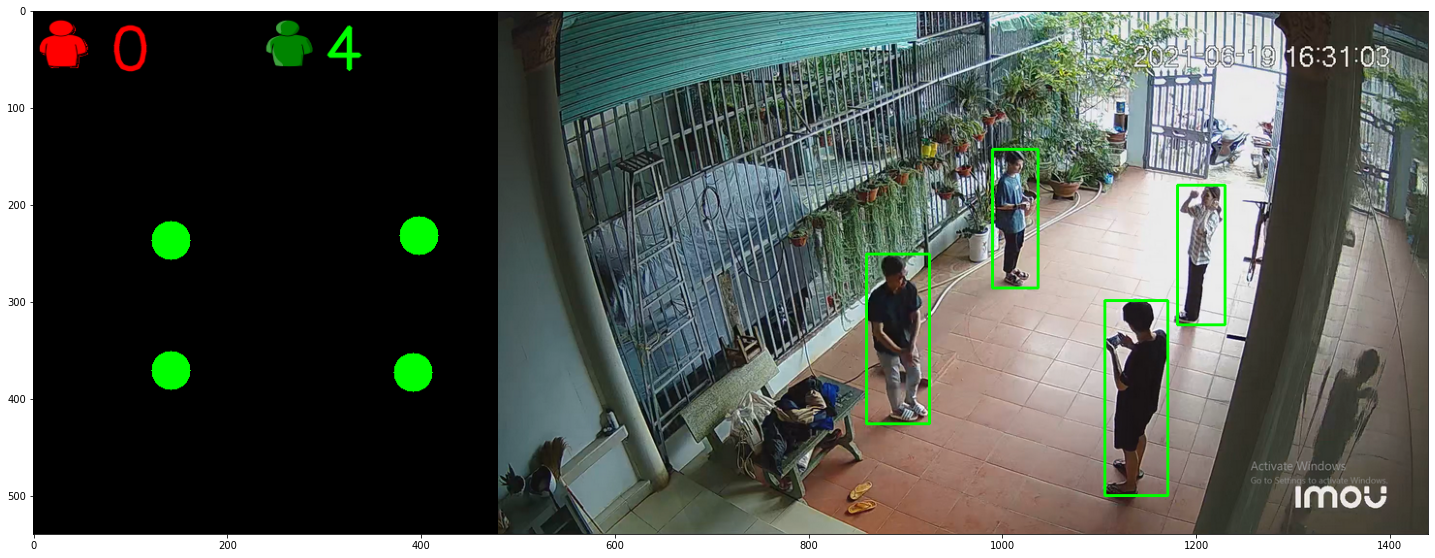

In [26]:
#Nối 2 ảnh đã handle
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

In [35]:
!pip install simplejpeg

     |████████████████████████████████| 276kB 8.4MB/s 


In [47]:
import numpy as np
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify, render_template,Response
import pickle
import cv2
import sys
from imutils.video import FileVideoStream
import simplejpeg
app = Flask(__name__,template_folder="/content/templates")
run_with_ngrok(app)
@app.route('/')
def home():
    return render_template('index.html')
@app.route('/detectObject' , methods=['POST'])
def mask_image():
	file = request.files['image'] ## byte file
	file.save("/content/data.avi")
	video=cv2.VideoCapture("/content/data.avi")
	ret,frame=video.read()
	if not ret:
		return jsonify({'error':True})
	return jsonify({'success':True})
####################### MONITOR SOCIAL DISTANCE ############################
image_height=540
image_width=960
def gen():
    frame_number = 0
    video = cv2.VideoCapture('/content/data.avi')
    min_distance=200
    while True:
        ret,frame = video.read()
        if not ret:
          break
        #Phát hiện người
        detections, width_ratio, height_ratio = darknet_helper(frame, 608, 608)
        boxes = [bbox for _,_,bbox in detections]
        #Tính lại location của people sau khi transform
        birds_eye_points = Point_transform_2(H_matrix, boxes)
        #Tính khoảng cách giữa các cặp điểm, xanh là không vi phạm, đỏ là vi phạm
        green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w,distance_h)
        #Display bird-eye-view
        birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)
        #Vẽ lại các rectangle theo khung hình
        box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)
        #Nối 2 ảnh lại bird-eye-view  và image_box
        combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)  
        frame=simplejpeg.encode_jpeg(image=combined_image,quality=70,colorspace='BGR',colorsubsampling='444')
        yield (b'--frame\r\n'b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
        del detections,birds_eye_view_image,box_red_green_image,combined_image
        key = cv2.waitKey(25)
        if key == 30:
          break
@app.route('/video_feed')
def video_feed():
	return Response(gen(), mimetype='multipart/x-mixed-replace; boundary=frame')
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c281c426f0f9.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/Jun/2021 10:10:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2021 10:10:15] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Jun/2021 10:10:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2021 10:10:23] "POST /detectObject HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2021 10:10:24] "GET /video_feed HTTP/1.1" 200 -


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, Response
import cv2
import sys
from imutils.video import FPS
from imutils.video import FileVideoStream

app=Flask(__name__,template_folder="/content/templates")
run_with_ngrok(app)

@app.route('/')
def index():
    """Video streaming home page."""
    return render_template('index.html')
H_matrix_flask=H_matrix
distance_h_flask=distance_h
distance_w_flask=distance_w
width_flask=width
height_flask=height
image_height_flask=image_height
image_width_flask=image_width
video = FileVideoStream('/content/People.mp4').start()
def gen(H_matrix_flask,width_flask,height_flask,image_height_flask,image_width_flask):
    frame_number = 0
    print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
    """Video streaming generator function."""
    # Read until video is completed
    min_distance=40
    while video.more():
        frame = video.read()
        detections, width_ratio, height_ratio = darknet_helper(frame, width_flask, height_flask)
        boxes = [bbox for _,_,bbox in detections]
        birds_eye_points = Point_transform(H_matrix_flask, boxes)
        green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w_flask,distance_h_flask)
        birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height_flask,eye_view_width=image_width_flask//2)
        box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

        combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
          
        frame = cv2.imencode('.jpg', combined_image)[1].tobytes()
        yield (b'--frame\r\n'b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
        del detections,combined_image,birds_eye_view_image
        #time.sleep(0.1)
        # del detections,combined_image,birds_eye_view_image
        key = cv2.waitKey(30)
        if key == 27:
           break   
@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(gen(H_matrix_flask,distance_w_flask,distance_h_flask,width_flask,height_flask,image_height_flask,image_width_flask),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

app.run()

In [ ]:
import sys
video = cv2.VideoCapture('/content/Home7_42.m4v')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  ret,frame = video.read()
  min_distance=200
  if not ret:
    break
  detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
  boxes = [bbox for _,_,bbox in detections]
  birds_eye_points = Point_transform_2(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes,distance_w,distance_h)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/test.avi', fourcc, 20, (combined_image.shape[1], combined_image.shape[0]), True)

  writer.write(combined_image)

  del detections,combined_image,birds_eye_view_image

print(' ')
writer.release()
video.release()